In this project we will be

- feature cleaning and engineering

- dimensionality reduction with feature selection and extraction


# Part 0: Environment Setup

In [2]:
# Set up our environment with comman libraries and plotting.
#    Note: generally we would do all of our imports here but some imports
#    have been left till later where they are used.

# Import numpy, pandas, matplotlib.pyplot and seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
%matplotlib inline

# Part 1: Data Cleaning and Feature Selection

In this section will be loading, cleaning and transforming a small set of data related to loan applications.

## Data Preparation

In [3]:
# Load Loan Application Data

# Read in the first dataframe containing loan application information.
df_loan = pd.read_csv('../data/hw3_loan.csv')

# Assert that the data is the correct shape
assert df_loan.shape == (664,4)

# Print the output of .info() called on df_loan 
print(df_loan.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 664 entries, 0 to 663
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CustomerID          664 non-null    int64  
 1   WasTheLoanApproved  664 non-null    object 
 2   LoanReason          641 non-null    object 
 3   RequestedAmount     652 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 20.9+ KB
None


In [4]:
# Deal with Duplicates

# Display rows with duplicate CustomerIDs
print(df_loan[df_loan.duplicated(subset='CustomerID', keep=False)])

# Drop one of the rows with duplicate CustomerID,
df_loan_nodups = df_loan.drop_duplicates(subset='CustomerID')

# We should only drop one row
assert df_loan_nodups.shape == (663,4)

     CustomerID WasTheLoanApproved LoanReason  RequestedAmount
650         736                  N     school           1001.0
651         736                  Y      other           2169.0


In [5]:
# Set the Index of df_loan_nodups

# Set the index of df_loan_nodups to the CustomerID column to make joining easier
df_loan_nodups = df_loan_nodups.set_index('CustomerID', drop=True)

# Display the first 3 rows of df_loan_nodups to visually confirm that the index has been set
df_loan_nodups.head(3)

,WasTheLoanApproved,LoanReason,RequestedAmount
CustomerID,,,
2,Y,goods,3074.0
3,Y,auto,939.0
4,Y,auto,2507.0


In [6]:
#Load Borrower Data

# Read in a second table containing borrower information.
df_borrower = pd.read_csv('../data/hw3_borrower.csv', index_col='CustomerID')

# Assert that the data is the correct shape
assert df_borrower.shape == (663,1)

# Print the output of .info() called on df_borrower
#  Note that the index has been set and there are no missing values
print(df_borrower.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 663 entries, 2 to 750
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     663 non-null    float64
dtypes: float64(1)
memory usage: 10.4 KB
None


In [7]:
# Join Datasets

# Join the df_loan_nodups and df_borrower datasets
df = df_loan_nodups.join(df_borrower, how='left')

# Assert that the data is the correct shape
assert df.shape == (663,4)

# Print the output of .info() called on df
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 663 entries, 2 to 750
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   WasTheLoanApproved  663 non-null    object 
 1   LoanReason          640 non-null    object 
 2   RequestedAmount     651 non-null    float64
 3   Age                 663 non-null    float64
dtypes: float64(2), object(2)
memory usage: 42.1+ KB
None


## Data Exploration and Transformation

In [8]:

# Instead of adding transformed features into our original dataframe (df) it is convenient to create a new dataframe containing only features.
# This will eventually be the X features for our models.
df_features = pd.DataFrame(index=df.index)

# Print the output of .info() called on df_features
# The index should match the index of df above, but empty otherwise
print(df_features.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 663 entries, 2 to 750
Empty DataFrameNone


### RequestedAmount

<Axes: xlabel='RequestedAmount', ylabel='Count'>

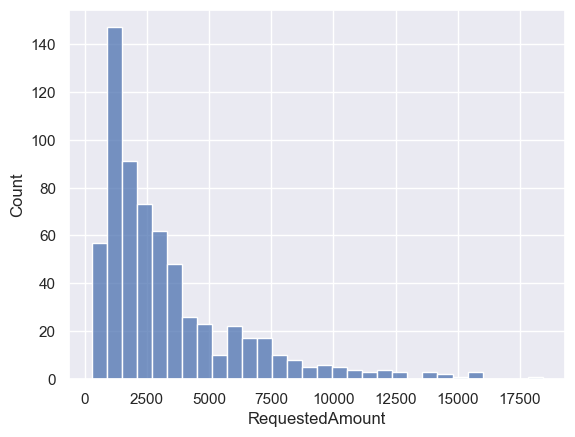

In [9]:
# Plot RequestedAmount

# RequestedAmount is a numeric feature with missing values

sns.histplot(df['RequestedAmount'])

In [10]:
# Create Dummy Column for Missing RequestedAmount 

# Before filling the missing values we should create a dummy variable to capture which rows had missing values

# Find the rows where RequestedAmount is missing and convert the resulting boolean values to integers
df_features['RequestedAmount_missing'] = df['RequestedAmount'].isnull().astype(int)

# Print the number of 0s and 1s in the RequestedAmount_missing column using .value_counts().
df_features['RequestedAmount_missing'].value_counts()

0    651
1     12
Name: RequestedAmount_missing, dtype: int64

In [11]:
# Fill Missing Values in RequestedAmount

# As RequestedAmount is right skewed, we'll fill missing values using median instead of mean.

# Print the median of RequestedAmount before filling
median_requested_amount = df['RequestedAmount'].median()
print(f'RequestedAmount median: {median_requested_amount}')

# Use fillna() to fill the missing values in RequestedAmount with the median of RequestedAmount
# We'll make two more transformations to this column before storing it as a feature so store back into df as 'RequestedAmount_filled'
df['RequestedAmount_filled'] = df['RequestedAmount'].fillna(df['RequestedAmount'].median())

# Print the median of RequestedAmount_filled. The median should not have changed after filling
print(f'RequestedAmount_filled median: {df["RequestedAmount_filled"].median()}')

# Assert that there are no longer any missing values in the RequestedAmount_filled column of df
assert df['RequestedAmount_filled'].isnull().sum() == 0

RequestedAmount median: 2329.0
RequestedAmount_filled median: 2329.0


<Axes: xlabel='RequestedAmount_log', ylabel='Count'>

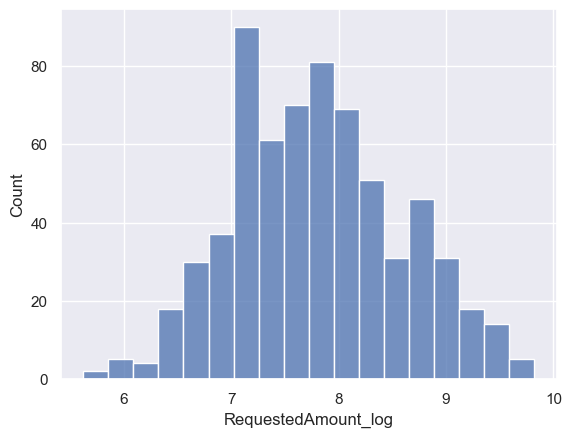

In [12]:
# Log Transform RequestedAmount

# Using .apply(), apply np.log (without parentheses) to the RequestedAmount_filled column.
# Store the result back into df as RequestedAmount_log
df['RequestedAmount_log'] = df['RequestedAmount_filled'].apply(np.log)

# Use seaborn histplot() (using default settings) to plot RequestedAmount_log 
# Note that the shape is now closer to a normal distribution
sns.histplot(df['RequestedAmount_log'])

In [13]:
# Center and Scale RequestedAmount_log Using StandardScaler

# Import StandardScaler from sklearn
from sklearn.preprocessing import StandardScaler

df_features['RequestedAmount_logscaled'] = StandardScaler().fit_transform(df[['RequestedAmount_log']])
print(df_features['RequestedAmount_logscaled'].agg(['mean', 'std']).round(2))

mean   -0.0
std     1.0
Name: RequestedAmount_logscaled, dtype: float64


### LoanReason

In [14]:
# LoanReason Values
print(df['LoanReason'].value_counts(dropna=False))

goods     299
auto      210
other      87
school     44
NaN        23
Name: LoanReason, dtype: int64


In [15]:
#  Fill Missing Values in LoanReason and Store in df_features

# Since this is a categorical variable, instead of creating a "missing" dummy column, simply fill the missing values with the string 'MISSING'

df_features['LoanReason'] = df['LoanReason'].fillna('MISSING')
print(df_features['LoanReason'].value_counts(dropna=False))


goods      299
auto       210
other       87
school      44
MISSING     23
Name: LoanReason, dtype: int64


### Age

In [16]:
# Scale and Store Ages

assert df['Age'].isnull().sum() == 0
print(df['Age'].agg(['min', 'max']))

min    19.0
max    75.0
Name: Age, dtype: float64


In [17]:
# Create Age Bin Edges for Age

# We'll transform Age into a categorical variable using binning.
age_bins = df['Age'].quantile([0, .33, .66, 1]).tolist()

# Print the bin edges
# Rows labeled 0.00 and 1.00 should have values that match the Age min and max seen printed above
print(age_bins)

[19.0, 29.0, 39.0, 75.0]


In [18]:
#  Bin Age

# Use pd.cut() to bin Age
df_features['Age'] = pd.cut(df['Age'], bins=age_bins, right=True, include_lowest=True)

# Print the first 3 rows of df_features.Age
print(df_features['Age'].head(3))

print() 

# Confirm the correct bins have been applied
print(df['Age'].head(3))

CustomerID
2      (29.0, 39.0]
3    (18.999, 29.0]
4      (39.0, 75.0]
Name: Age, dtype: category
Categories (3, interval[float64, right]): [(18.999, 29.0] < (29.0, 39.0] < (39.0, 75.0]]

CustomerID
2    33.0
3    28.0
4    51.0
Name: Age, dtype: float64


### One-Hot Encode Categorical Variables

In [19]:
# Transform LoanReason and Age Bins using One-Hot Encoding


print(df_features.head(3).round(2).T)

# Use pd.get_dummies() to encode the categorical variables
df_features_ohe = pd.get_dummies(df_features)

print(df_features_ohe.head(3).round(2).T)

assert df_features_ohe.shape == (663,10)

CustomerID                            2               3             4
RequestedAmount_missing               0               0             0
RequestedAmount_logscaled          0.31           -1.21          0.04
LoanReason                        goods            auto          auto
Age                        (29.0, 39.0]  (18.999, 29.0]  (39.0, 75.0]
CustomerID                    2     3     4
RequestedAmount_missing    0.00  0.00  0.00
RequestedAmount_logscaled  0.31 -1.21  0.04
LoanReason_MISSING         0.00  0.00  0.00
LoanReason_auto            0.00  1.00  1.00
LoanReason_goods           1.00  0.00  0.00
LoanReason_other           0.00  0.00  0.00
LoanReason_school          0.00  0.00  0.00
Age_(18.999, 29.0]         0.00  1.00  0.00
Age_(29.0, 39.0]           1.00  0.00  0.00
Age_(39.0, 75.0]           0.00  0.00  1.00


# Part 2: Feature Selection

In [20]:
#  Transform Target 

# The target we're interested in predicting is df.WasTheLoanApproved.
# This is a categorical variable taking the values Y for yes and N for no

y = df['WasTheLoanApproved'].map({'Y': 1, 'N': 0})

# Print the proportion of positives (1's) in y with a precision of 2. We can use this as our baseline accuracy (what would be found by a DummyClassifier)
#  We'd like to find a model that does better than this
print(f'proportion of positives in y: {y.mean():.2f}')

proportion of positives in y: 0.59


In [21]:
#  Split the Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_features_ohe, y, test_size=0.1, stratify=y, random_state=512)

# Assert that X_train has 596 rows, 10 columns
assert X_train.shape == (596,10)

print(f'proportion of positives in y_test: {y_test.mean():.2f}')

proportion of positives in y_test: 0.60


In [22]:
# Rank Feature Importance Using GradientBoostingClassifier


from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=10, max_depth=5)


# Fit gbc on the training set
gbc.fit(X_train, y_train)

# The feature_importances_ stored in gbc are in the order of the columns of X_train
gbc_feature_importances = pd.Series(gbc.feature_importances_, index=X_train.columns)

# Display feature_importances sorted by value descending rounded to a precision of 2
print(gbc_feature_importances.sort_values(ascending=False).round(2))

RequestedAmount_logscaled    0.49
Age_(18.999, 29.0]           0.38
Age_(29.0, 39.0]             0.03
Age_(39.0, 75.0]             0.02
LoanReason_auto              0.02
LoanReason_school            0.02
LoanReason_other             0.02
LoanReason_goods             0.02
RequestedAmount_missing      0.01
LoanReason_MISSING           0.00
dtype: float64


In [23]:
# Feature Selection with SelectFromModel

from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(gbc, threshold='mean')
sfm.fit(X_train, y_train)

# Show the selected features using X_train.columns and sfm.get_support()
selected_features = X_train.columns[sfm.get_support()]
print(selected_features)

Index(['RequestedAmount_logscaled', 'Age_(18.999, 29.0]'], dtype='object')


In [24]:
# Transform Data Using Selected Features

# Create a new dataset using only the features selected in the previous step.
X_train_fs = sfm.transform(X_train)
X_test_fs = sfm.transform(X_test)

# Assert that X_train_fs has 596 rows and 2 columns.
assert X_train_fs.shape == (596,2)

# Print the first 3 rows of X_train_fs, rounded to a precision of 2
print(X_train_fs[:3].round(2))



[[ 0.13  1.  ]
 [-1.28  0.  ]
 [ 0.08  0.  ]]


In [25]:
# Train and Evaluate Model On Selected Features

gbc_fs = GradientBoostingClassifier(n_estimators=10, max_depth=5)
gbc_fs.fit(X_train_fs, y_train)

# Train the gbc_fs model on X_train_fs and y_train
train_accuracy = gbc_fs.score(X_train_fs, y_train)
test_accuracy = gbc_fs.score(X_test_fs, y_test)

# Print the accuracy achieved by gbc_fs on both training and test set
print(f'training accuracy: {train_accuracy:.2f}')
print(f'test accuracy    : {test_accuracy:.2f}')


training accuracy: 0.77
test accuracy    : 0.69


## Part 3: Feature Extraction

In [26]:
# Reduce Dataset to 2D Using PCA

# Import PCA from sklearn
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=512)

# Fit and transform the full X_train to 2D using pca
X_train_pca = pca.fit_transform(X_train)

# Transform (but don't fit!) the X_test to 2D using the trained pca
# Store in X_test_pca
X_test_pca = pca.transform(X_test)

# Print the ratio of variance explained by each component in pca, rounded to a precision of 2
print(pca.explained_variance_ratio_.round(2))

[0.44 0.16]


In [27]:
# Train and evaluate a classifier using the PCA representation

gbc_pca = GradientBoostingClassifier(n_estimators=10, max_depth=5)
gbc_pca.fit(X_train_pca, y_train)

train_accuracy_pca = gbc_pca.score(X_train_pca, y_train)
test_accuracy_pca = gbc_pca.score(X_test_pca, y_test)

# Print the accuracy achieved by gbc_pca on both training an test set
print(f'training accuracy: {train_accuracy_pca:.2f}')
print(f'test accuracy    : {test_accuracy_pca:.2f}')


training accuracy: 0.72
test accuracy    : 0.66
